<a href="https://colab.research.google.com/github/Andrew-TraverseMT/placekey-joins/blob/main/CMS_hopital_and_payment_join.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Exploring The Relationship between Payments and Hospital Overall Ratings by Joining CMS Data with Placekey

In the context of CMS (Centers for Medicare & Medicaid Services) data, the overall hospital rating represents a summary measure of the quality of care provided by a hospital. This rating is part of the CMS Hospital Compare program, which aims to provide consumers with information to make informed decisions about healthcare. Here, we join hospital overall ratings data with payments data to explore how strongly the payments for various services correspond to the overall rating.

### Environment Setup to Read from Drive

> Using awscli, we can pull in the skinny mappings from s3



In [1]:
!pip install polars awscli

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.6/4.6 MB 28.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 40.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 548.2/548.2 kB 14.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.2/84.2 kB 5.2 MB/s eta 0:00:00
  Attempting uninstall: rsa
    Found existing installation: rsa 4.9
    Uninstalling rsa-4.9:
      Successfully uninstalled rsa-4.9
  Attempting uninstall: docutils
    Found existing installation: docutils 0.21.2
    Uninstalling docutils-0.21.2:
      Successfully uninstalled docutils-0.21.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
sphinx 8.1.3 requires docutils<0.22,>=0.20, but you have docutils 0.16 which is incompatible.


In [2]:
!aws s3 --no-sign-request cp s3://placekey-free-datasets/hospital-payment-value-data-from-cms/csv/hospital-payment-value-data-from-cms.csv /content/data/

download: s3://placekey-free-datasets/hospital-payment-value-data-from-cms/csv/hospital-payment-value-data-from-cms.csv to data/hospital-payment-value-data-from-cms.csv


In [3]:
!aws s3 --no-sign-request cp s3://placekey-free-datasets/hospital-data-from-cms/csv/hospital-data-from-cms.csv /content/data/

download: s3://placekey-free-datasets/hospital-data-from-cms/csv/hospital-data-from-cms.csv to data/hospital-data-from-cms.csv


### Diving into the Join

> At this point, you have both files to begin the join `/content/data/hospital-payment-value-data-from-cms.csv` and `/content/data/hospital-data-from-cms.csv`

### Joining the Values
> Now, we can complete the join. Here we are joining hospital payment value data from CMS (left) to hospital data from CMS (right).

In [49]:
import pandas as pd

payments = pd.read_csv('/content/data/hospital-payment-value-data-from-cms.csv')

hospital = pd.read_csv('/content/data/hospital-data-from-cms.csv')

In [88]:
joined_df = pd.merge(payments, hospital, on='placekey', how='left')

### Exploring the relationship between hospital overall rating (from the hospital data) and payments

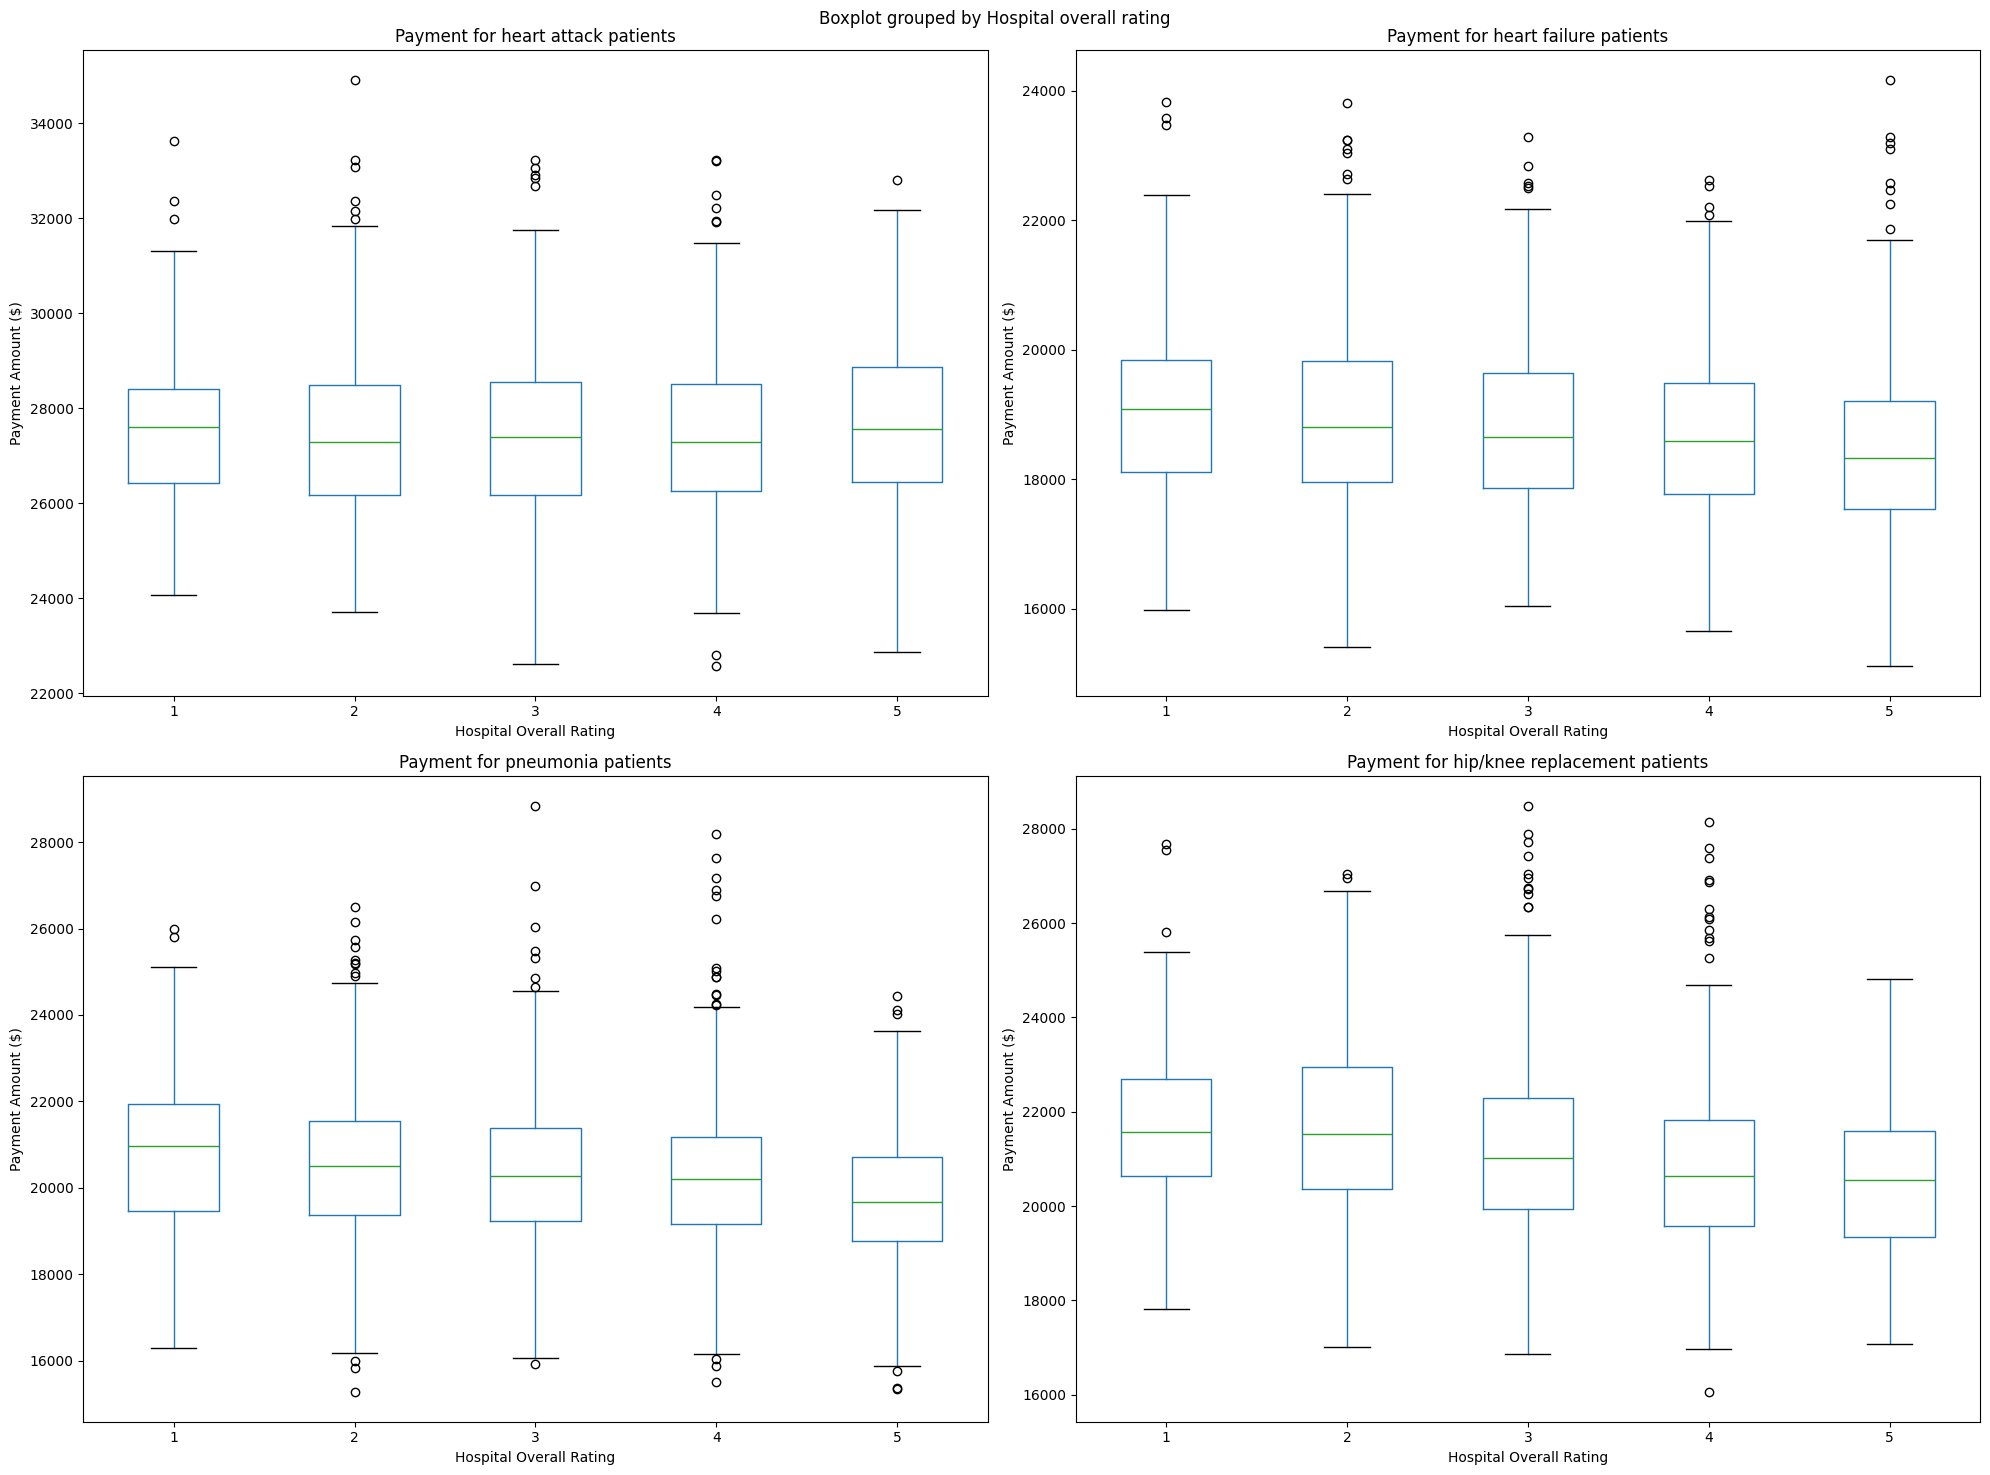

In [89]:
import matplotlib.pyplot as plt
import numpy as np

# Preprocess the 'Payment' column
joined_df['Payment'] = joined_df['Payment'].apply(lambda x: 0 if x == 'Not Available' else float(x.replace('$', '').replace(',', '')))

# Drop rows where 'Hospital overall rating' is "Not Available" or null
df_cleaned = joined_df[joined_df['Hospital overall rating'] != 'Not Available'].dropna(subset=['Hospital overall rating'])
# Convert 'Hospital overall rating' to numeric if it's not already
df_cleaned['Hospital overall rating'] = pd.to_numeric(df_cleaned['Hospital overall rating'], errors='coerce')
# Drop any new NaN values that might have been introduced by conversion
df_cleaned = df_cleaned.dropna(subset=['Hospital overall rating'])
# Exclude payment values of zero
df_cleaned = df_cleaned[df_cleaned['Payment'] != 0]
# Get unique payment measure names
unique_measures = df_cleaned['Payment Measure Name'].unique()
# Create a figure with subplots
fig, axes = plt.subplots(2, 2, figsize=(20, 15))
fig.suptitle('Box Plots of Payments by Hospital Overall Rating for Different Payment Measures', fontsize=16)
# Flatten the axes array for easy iteration
axes = axes.ravel()
# Loop through each unique payment measure
for i, measure in enumerate(unique_measures):
    # Filter the DataFrame for the current measure
    measure_df = df_cleaned[df_cleaned['Payment Measure Name'] == measure]

    # Plot the box plot
    measure_df.boxplot(column='Payment', by='Hospital overall rating', ax=axes[i], grid=False)

    # Set title for each subplot
    axes[i].set_title(measure)
    axes[i].set_xlabel('Hospital Overall Rating')
    axes[i].set_ylabel('Payment Amount ($)')
# Adjust layout to prevent overlapping
plt.tight_layout()
plt.show()

### Preparing data for mapping

In [58]:
# Convert to float where necessary
joined_df['geocode_latitude'] = joined_df['geocode_latitude'].astype(float)
joined_df['geocode_longitude'] = joined_df['geocode_longitude'].astype(float)
# Select relevant columns for mapping
map_data = joined_df[['Address_x', 'City/Town_x', 'State_x', 'ZIP Code_x', 'geocode_latitude', 'geocode_longitude', 'Count of MORT Measures Better', 'Count of Safety Measures Better', 'Facility Name_x']]

In [60]:
import geopandas as gpd

# Create a GeoDataFrame
gdf = gpd.GeoDataFrame(
    map_data,
    geometry=gpd.points_from_xy(map_data['geocode_longitude'], map_data['geocode_latitude'])
)
# Set the coordinate reference system (CRS) to WGS84, which is standard for latitude and longitude
gdf.crs = 'EPSG:4326'